In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
from itertools import product
import plot_func as pf
import plotly.graph_objects as go

# MAKE SOME NOISE

> <i>" To Ken Perlin for the development of Perlin Noise, a technique used to produce natural appearing textures on computer generated surfaces for motion picture visual effects. The development of Perlin Noise has allowed computer graphics artists to better represent the complexity of natural phenomena in visual effects for the motion picture industry."</i>

Computer scientist Ken Perlin received this recognition in 1997 when he won an Oscar for Technical Achievement
from the Academy of Motion Picture Arts and Sciences for his noise and turbulence procedural texturing techniques
which he developed in the early 80's.
Without his efforts the exiting world of computer games and movies like "Star Wars", "Terminator" would not be the same.

<img src="Images/Toy Story.jpg" alt="Drawing"/>
<i><center>Toy Story(1995)</center></i>


  

### 1. Brief history
When he had been working on "[Tron](https://www.imdb.com/title/tt0084827/)" (1982), one of the first movies widely used computer-generated imagery (CGI), he felt frustrated by non-natural enough looking textures. 
To some degree this unwanted effect was result of limitations of then existed computer technology. The limited memory didn't allow detailed texture images to be fitted into the memory.

<img src="Images/Tron.jpg" alt="Drawing"/>
<i><center>Poster from the movie "Tron"(1982)</center></i>

### 2. The algorithm

  Perlin statred development of procedural textures which are charachterized by fast generation, less  resources usage and easier application on 3D objects. With procedural textures one doesn't suffer the problems when needs to "wrap" a 2D image properly around a 3D object - imagine wraping an atlas over a globe. This is how Perlin came up with the idea for an algorithm which produces "natural looking" noise. 
To a more natural appearance textures should be smoother. The transitions between high and low points should not be extreme. We can consider a good pseudo-random generator for a ideal source of a "normal" noise. Let's see how it looks like.


In [3]:
_1d_normal_noise = np.random.rand(100, 1)    # array with 100 points
_2d_normal_noise = np.random.rand(100, 100)  # array with 100x100 points

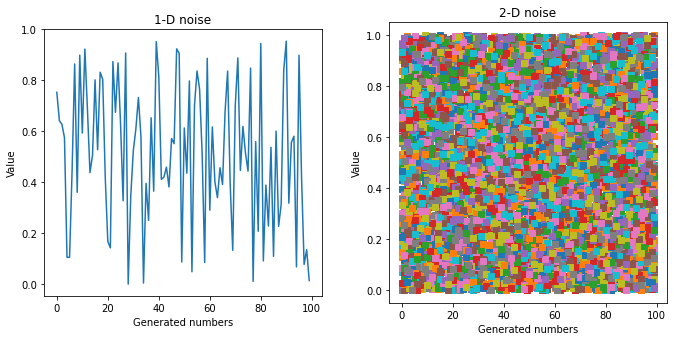

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(_1d_normal_noise)
ax1.set_title("1-D noise")

ax2.plot(_2d_normal_noise, "s")
ax2.set_title("2-D noise")

for axi in [ax1, ax2]:
    axi.set(xlabel='Generated numbers', ylabel='Value')
    axi.set_aspect("100")

fig.set_size_inches(10,10, forward=True)
fig.tight_layout(pad = 3)

# ax2.imshow(_2d_normal_noise, cmap='gray', vmin=0, vmax=1)
plt.show()



Well, that doesn't appear very smooth. If you want to emulate the fall of a leaf you definitely can't use the 1-D noise we generated as a path. And if you try to put some rust on a 3D metal ball you just modelled it will look more like it's bombarded with acid.

<img src="Images/Rusted_Ball.png" alt="Drawing" style="width: 270px;"/>
<i><center>Rust texture made with procedural noise applied on a 3D ball</center></i>

### So let's make some noise!

But we need to establish some ground rules first:
* A 1D / 2D / 3D noise functions are functions taking 1D / 2D / 3D points as input parameters.
* The noise function is pseudo-random - i.e. it looks random but given the same input, it always returns the same value.
* It takes a n-dimensional point with real coordinates as input and returns a float or array of floats in for the case with more than one dimension. For Perlin noise the typical range is $[-1.0,1.0]$
* The function should be continuous - we will need to calculate its derivatives in some places.
* The function should be differentiable - some functions are continuous but not differentiable at some points 
([Weierstrass Function](https://en.wikipedia.org/wiki/Weierstrass_function)).
* The function should be periodic - *$ f(𝑥+T) = f(𝑥), T \in \mathbb{Z^+} $*. We want repeated patterns to connect seamlessly.



<img src="Images/Seamless.png" alt="Drawing"  style = "width: 650px;" />
<i><center>Example of seamless texture. Each end connects seamlessly when repeated.</center></i>

Also few clarifications should be added. When we speak for a _grid_ that means we speak for a grid of pixels(2D), voxels(3D), etc.(unfortunately the human visual perception stops here). The grid is defined by points and every point has integers as coordinates. What the noise function calculates is the value contained in particular cell(pixel) or cube(voxel). With that said let's continue.

### The recipe

It's an easy one but ingenious.


As input we take points with $n$ given coordinates in $n$-dimensional space. Тhese points lie between the grid points. It is possible points to be on top of the grid points, but this will be _pointless_ and we will see that further in the explanation.

In [5]:
grid_points = np.array(list(product(range(1,5), range(1,3))))
rand_points = np.array([[2.65, 1.79],[1.45, 1.39],  [3.65, 1.59]])

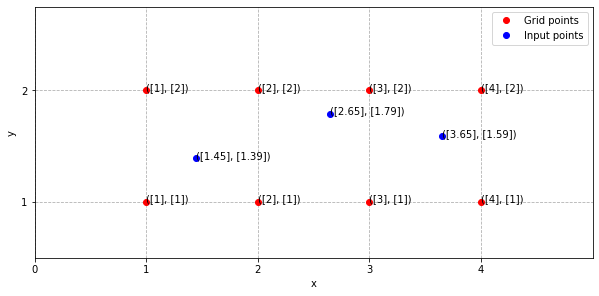

In [6]:
plt.figure(figsize = (10, 8))

# plot points
pf.plot_points(grid_points[:,:1], grid_points[:,1:], "ro")
pf.plot_points(rand_points[:,:1], rand_points[:,1:], "bo")

pf.def_axes(["Grid points", "Input points"], xlim=[0.5, 5], ylim=[0.5,2.75], ax_labels=["x","y"], ticks=[range(5),range(1,3)])
plt.show()


First we find where in the grid this point lie and then we calculate the _vectors_ from each corner of the grid to that point. Then we choose $n$ pseudorandom _gradient vectors_ also called _unit vectors_ for each corner.

For 2D noise the gradient vectors are given by $$g_i,_j = G[P[P[X]+Y]]$$ and for 3D: $$g_x,_y,_z = G[P[P[P[X]+Y]+Z]]$$


where $X,Y,Z$ are the coordinates of the grid point and $P$ is a permutation table which usualy is precomputed.
 
> _P = [151, 160, 137, 91, 90, 15, 131, 13, 201, 95, 96, 53, 194, 233, 7, 225, 140, 36, 103, 30, 69, 142, 8, 99, 37, 240, 21, 10, 23, 190, 6, 148, 247, 120, 234, 75, 0, 26, 197, 62, 94, 252, 219, 203, 117, 35, 11, 32, 57, 177, 33, 88, 237, 149, 56,87, 174, 20, 125, 136, 171, 168, 68, 175, 74, 165, 71, 134, 139, 48, 27, 166, 77, 146, 158, 231, 83, 111, 229, 122, 60, 211, 133, 230, 220, 105, 92, 41, 55, 46, 245, 40, 244, 102, 143, 54, 65, 25, 63, 161, 1, 216, 80, 73, 209, 76, 132, 187, 208, 89, 18, 169, 200, 196, 135, 130, 116, 188, 159, 86, 164, 100, 109, 198, 173, 186, 3, 64, 52, 217, 226, 250, 124, 123, 5, 202, 38, 147, 118, 126, 255, 82, 85, 212, 207, 206, 59, 227, 47, 16, 58, 17, 182, 189, 28, 42, 223, 183, 170, 213, 119, 248, 152, 2, 44, 154, 163, 70, 221, 153, 101, 155, 167, 43, 172, 9, 129, 22, 39, 253, 19, 98, 108, 110, 79, 113, 224, 232, 178, 185, 112, 104, 218, 246, 97, 228, 251, 34, 242, 193, 238, 210, 144, 12, 191, 179, 162, 241, 81, 51, 145, 235, 249, 14, 239, 107, 49, 192, 214, 31, 181, 199, 106, 157, 184, 84, 204, 176, 115, 121, 50, 45, 127, 4, 150, 254, 138, 236, 205, 93, 222, 114, 67, 29, 24, 72, 243, 141, 128, 195, 78, 66, 215, 61, 156, 180]_

<i><center>The original permutation table used by Ken Perlin.</center></i>

The table contains all the numbers from $0$ to $m$. $m$ could be arbitrarily big, but if we want repeatability then the table should be reasonably small (128/256/512). Also number who are powers of 2 are considered better to be used for faster computation which with the contemporary processors is arguable.

$$m \in \mathbb{Z^+}, m = [0,127]$ or $m = [0,255]$ or $m = [0,511]$$

We pick the values from the permutation table using the grid coordinates. If a grid axis is bigger than the length of the permutation table then we take the modulus of $n$ from the axis value. This will guarantee the same values will be assigned every $m$ points. With other words: $$g_x,_y,_z = G[P[(P[(P[X \bmod m]+Y) \bmod m]+Z) \bmod m]]$$



G contains pseudo-random unit-length gradient vectors which are picked in way that their directions are away from the coordinate axes. Let's say we have a square lying on the $xy$ plane with center in $[0,0]$ and side = 2 units. The gradient vectors we pick are the ones that start from the center and end at the corners of the square.

In [7]:
square_x = np.array([-1, 1, -1, 1, 0])  # x coordinates of the square
square_y = np.array([1, 1, -1, -1, 0])  # y coordinates of the square

unit_vectors = np.array([[1, 1], [1, -1], [-1, 1], [-1, -1]]) # The gradient vectors

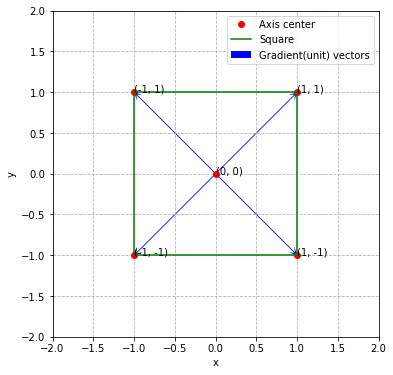

In [8]:
plt.figure(figsize = (6,6))

# plot points
pf.plot_points(square_x, square_y, c = "ro")
pf.plot_square(1)

# plot gradient vectors
plt.quiver([0,0,0,0], [0,0,0,0], unit_vectors[:,:1], unit_vectors[:,1:], color = "blue", width = 0.01, headwidth = 10, headlength = 10, units = "xy", scale = 1)
pf.def_axes(["Axis center", "Square", "Gradient(unit) vectors"], xlim=[-2, 2], ylim=[-2, 2], ax_labels=["x","y"]) #ticks=[range(5),range(1,3)]

For 3D these squeres are three and lie on $xy$, $xz$ and $yz$ planes. This setup produces 12 gradient vectors, but for convinience(powers of two, remember) we repeat four of them.

G for 2D:
$$(1,1), (1,-1), (-1,1), (-1,-1)$$

G for 3D:
$$(1,1,0),(-1,1,0),(1,-1,0),(-1,-1,0),$$
$$(1,0,1),(-1,0,1),(1,0,-1),(-1,0,-1),$$
$$(0,1,1),(0,-1,1),(0,1,-1),(0,-1,-1),$$
$$(1,1,0),(-1,1,0),(0,-1,1),(0,-1,-1)$$

The function G[p] could also be every function which produces a unit vector and uses $n$ times permutions of the parameter it uses. For example:

$$G[p] = a.sin(p) + b.cos(p)$$

### Gradient vectors

All the time we talk about _gradient vectors_, but what exactly they do for us. As we know a gradient vector is the slope of a function derivative in a particular point and gives us the rate of change of this function in that point. With other words gradient vectors will determine towards where the value of the pixel is "pulled".

<img src="Images/Gradients.png" alt="Drawing"  style = "width: 650px;" />
<i><center>Values pulled towards the gradient vectors. (Source: Wikipedia.org)</center></i>

Now let's visualise the whole picture.

In [9]:
point_coor = [0.72, 0.34]  # random point coordinates
grid_x = np.array([-1, 1, -1, 1])  # x coordinates of the bounding box
grid_y = np.array([1, 1, -1, -1])  # y coordinates of the bounding box
grid_points = np.array(list(zip(grid_x, grid_y))) #  Grid points
offset_vectors = np.array([point_coor] * 4) - grid_points # The inner vectors from the corners to the point

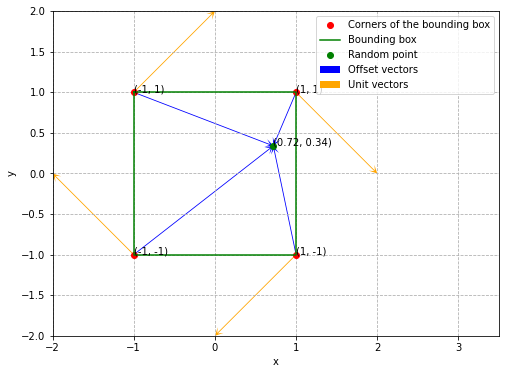

In [10]:
plt.figure(figsize = (8,8))

# plot points
pf.plot_points(grid_x, grid_y, c = "ro")
pf.plot_square(1)
pf.plot_points([point_coor[0]], [point_coor[1]], c = "go")

# plot offset vectors
plt.quiver(grid_points[:,:1], grid_points[:,1:], offset_vectors[:,:1], offset_vectors[:,1:], color = "blue", width = 0.01, headwidth = 10, headlength = 10, units = "xy", scale = 1)

# plot gradient vectors
plt.quiver(grid_points[:,:1], grid_points[:,1:], unit_vectors[:,:1], unit_vectors[:,1:], color = "orange", width = 0.01, headwidth = 10, headlength = 10, units = "xy", scale = 1)

pf.def_axes(["Corners of the bounding box", "Bounding box", "Random point", "Offset vectors", "Unit vectors"], xlim=[-2, 3.5], ylim=[-2, 2], ax_labels=["x","y"])
plt.show()

We have a bunch of vectors and points, and we need to determine the value of our pixel. We do that by calculating the dot product between the two vectors of every grid point. That will gives us four values. Then we interpolate every couple of values lying on а same line parallel to a axis and the two newly produced values are interpolated again in order to produce single value which will be the value of the noise for that pixel.

Interpolation is done by using the function
$$f(t) = x_1 + t . (x_1 - x_0)$$
where $x_0$ and $x_1$ are two neighbour points lying on a line parallel to a axis, i.e. two of the corners of the bounding box of the random point.



<img src="Images/Offset.png" alt="Drawing"  style = "width: 878px;" />
<i><center>Offset $x_i - x_0$ along the x axis.</center></i>

The value of $t$ is first "faded" or "smoothed" using a function $f(t)$ for which $f(0) = 0$ and $f(1) = 1$. They are characterised with "S"-shaped curve in [0,1] range. Such functions are:

$$f(t) = 3t^2 - 2t^3$$
$$f(t) = 6t^5 - 15t^4 + 10t^3$$

In [11]:
t = np.arange(0, 1, 0.01)
f1 = np.array(list(map(lambda x: 3*x**2 - 2*x**3, t)))
f2 = np.array(list(map(lambda x: 6*x**5 - 15*x**4 + 10*x**3, t)))

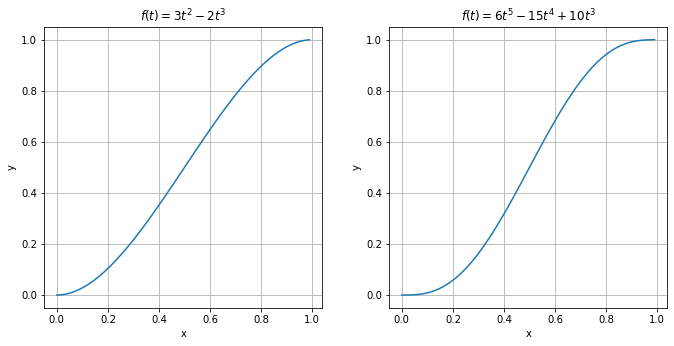

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(t, f1)
ax1.set_title("$f(t) = 3t^2 - 2t^3$")

ax2.plot(t, f2)
ax2.set_title("$f(t) = 6t^5 - 15t^4 + 10t^3$")

for axi in [ax1, ax2]:
    axi.set(xlabel='x', ylabel='y')
    axi.set_aspect("1")
    axi.grid()


fig.set_size_inches(10,10, forward=True)
fig.tight_layout(pad = 3)

plt.show()

The first function was originaly used, but the second was introduced in the improved version by Ken Perlin. The second derivative of the first function is non-zero at $t = 0$ and $t = 1$ which causes "harsh" changes in the values around the borders of the bounding box.

Remember when we said that we can't use integers as input. Now you understand that in this case our pixel will be noisless(actualy black) because the dot product between the two vectors will be 0. Both gradient and inner vectors will be $[0,0]$.

One main thing left to be mentioned and that is the concept for the octaves or more correctly frequencies. These are done by multiplying the input by a certain number usually a power of 2. If we multiply with 2 this will double the resolution. On the other hand if we devide the output by two we'll bring back the resolution and willl lower the amplitude. So what? Well, the magic happens when we combine few outputs from different octaves.

Bellow is the python code for perlin noise with few examples given.

In [13]:
def get_constant_vector(p):
    # p is the value from the permutation table
    # these are the four gradient vectors
    vec = p % 3
    
    if vec == 0:
        return [1.0, 1.0]
    elif vec == 1:
        return [-1.0, 1.0]
    elif vec == 2:
        return [1.0, -1.0]
    else:
        return [-1.0, -1.0]

    
def lerp(t, a1, a2):
    # the function for linear interpolation
    return a1 + t * (a2 - a1)


def fade(t):
    #fading/smooothing function
    return 6 * t ** 5 - 15 * t ** 4 + 10*t**3


def _dot(x, y, const_vec):
    # function for computing the dot product
    value = x * const_vec[0] + y * const_vec[1]
    return value
    


def noise_2d(x, y, octave = 1, seed = None):
    
    # P = permutation = shufled numbers from 0 to 255.
    permutation = (151,160,137,91,90,15, 
        131,13,201,95,96,53,194,233,7,225,140,36,103,30,69,142,8,99,37,240,21,10,23, 
        190,6,148,247,120,234,75,0,26,197,62,94,252,219,203,117,35,11,32,57,177,33, 
        88,237,149,56,87,174,20,125,136,171,168,68,175,74,165,71,134,139,48,27,166, 
        77,146,158,231,83,111,229,122,60,211,133,230,220,105,92,41,55,46,245,40,244, 
        102,143,54,65,25,63,161,1,216,80,73,209,76,132,187,208,89,18,169,200,196, 
        135,130,116,188,159,86,164,100,109,198,173,186,3,64,52,217,226,250,124,123, 
        5,202,38,147,118,126,255,82,85,212,207,206,59,227,47,16,58,17,182,189,28,42, 
        223,183,170,213,119,248,152,2,44,154,163,70,221,153,101,155,167,43,172,9, 
        129,22,39,253,9,98,108,110,79,113,224,232,178,185,112,104,218,246,97,228, 
        251,34,242,193,238,210,144,12,191,179,162,241, 81,51,145,235,249,14,239,107, 
        49,192,214,31,181,199,106,157,184,84,204,176,115,121,50,45,127,4,150,254, 
        138,236,205,93,222,114,67,29,24,72,243,141,128,195,78,66,215,61,156,180)
    
    P = permutation * 2
    
    
    # inputs should be between 0 and 1
    x /= 255
    y /= 255
    
    # frequency/octave
    x *= octave
    y *= octave

    
    # ---------- inner vectors
    X = math.floor(x) % 255  # the nearest left integer to the point along x axis
    Y = math.floor(y) % 255  # the nearest down integer to the point along y axis

    xi = x - math.floor(x)   #weights
    yi = y - math.floor(y)
    
    TL = [xi, yi - 1]      # inner vector from the top left corner
    TR = [xi - 1, yi - 1]  # inner vector from the top right corner
    BR = [xi - 1, yi]      # inner vector from the bottom right corner
    BL = [xi, yi]          # inner vector from the bottom left corner
    
    # Select a value in the array for each of the 4 corners.
    # Every corner should have the same value always.
    # The code bellow ensures we have same unique value for every corner.
    value_TL = P[P[X] + Y + 1]
    value_TR = P[P[X + 1] + Y + 1]
    value_BR = P[P[X + 1] + Y]
    value_BL = P[P[X] + Y]
    

        
    # Genrate gradient vectors (unit/constant vectors) and calculating the dot product with the inner vectors
    dot_TL = np.dot(TL, get_constant_vector(value_TL))
    dot_TR = np.dot(TR, get_constant_vector(value_TR))
    dot_BR = np.dot(BR, get_constant_vector(value_BR))
    dot_BL = np.dot(BL, get_constant_vector(value_BL))
    
    
    # Now that we have the dot product for each corner, we need to somehow mix them to get a single value.
    # For this, we’ll use interpolation.
    # a1 and a2 are the two values we want to interpolate. in our case two of the dot products.
    # t is a weight.
    # if a1 is 10, a2 is 20 and t is 0.4 (so 40%) the interpolated
    # value would be 14 because it’s at 40% of the way between 10 and 20 (40% or 0.4).

    # instead of t (xi and yi in our case) we will use the smoothed version of it
    u = fade(xi)
    v = fade(yi)
    
    
    
    # interploate BL with TL and BR with TR, then we interpolate the two resulting values.
    # as weights the offsets of x and respectively y are used when interpolation is on x and y axes
    value = lerp(u,
        lerp(v, dot_BL, dot_TL),
        lerp(v, dot_BR, dot_TR)
    )
    
    return value

In [14]:
def run_perlin_noise(n, octave=1, permutation_table=None):
    
    pic = np.zeros((n, n, 1))    
    for x in range(n):
        for y in range(n):
            point = noise_2d(x, y, octave, permutation_table)
            
            point += 1
            point /= 2
            pic[x,y] = point
    return pic

In [15]:
pic0 = run_perlin_noise(128, octave = 1)
pic1 = run_perlin_noise(128, octave = 2)
pic2 = run_perlin_noise(128, octave = 4)
pic3 = run_perlin_noise(128, octave = 8)
pic4 = run_perlin_noise(128, octave = 16)
pic5 = run_perlin_noise(128, octave = 32)
pic6 = run_perlin_noise(128, octave = 64)

#This is how the cloudy look is accomplished
pic_all1 = pic0 + 0.5 * pic1 + 0.25 * pic2 + 0.125 * pic3 + 0.0625 * pic4
pic_all2 = pic1 + 0.5 * pic2 + 0.25 * pic3 + 0.125 * pic4 + 0.0625 * pic5

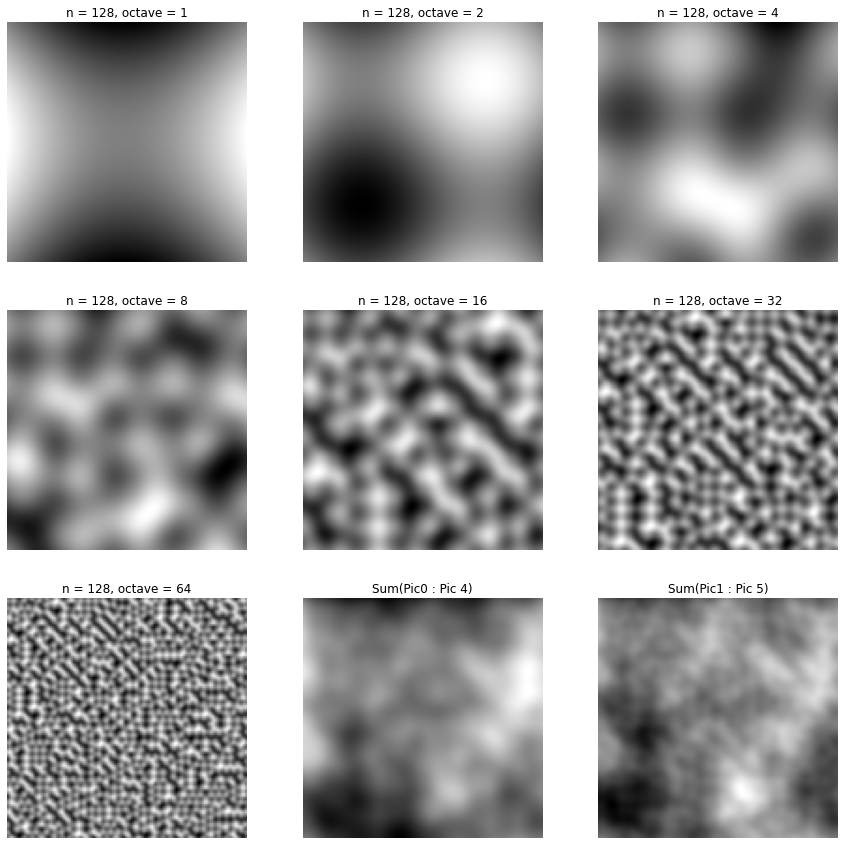

In [16]:
pf.plot_first_noise([pic0, pic1, pic2, pic3, pic4, pic5, pic6, pic_all1, pic_all2])

In the next picture the noise values are used to alter the RGB values. 

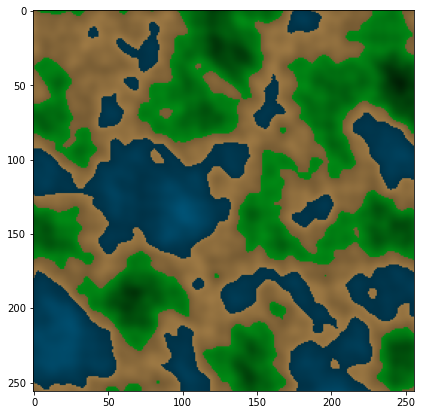

In [17]:
# Render islands
n = 256
seed = 777

pic_islands = np.zeros((n, n, 3))
for x in range(n):
    for y in range(n):
        point =        noise_2d(x, y, 3, seed)
        point += 0.5 * noise_2d(x, y, 6, seed)
        point += 0.25 * noise_2d(x, y, 12, seed)
        point += 0.125 * noise_2d(x, y, 24, seed)

        point += 1
        point /= 2
        
        
        if point < 0.45:
            pic_islands[x,y] = [0, (154 * 2 * point)/255, (23 * 2 * point)/255]  # green
        
        elif point > 0.6:
            pic_islands[x,y] = [0, (41 * 2 * point)/255, (58 * 2 * point)/255]  # blue
        
        else:
            pic_islands[x,y] = [(131 * 2 * point)/255, (101 * 2 * point)/255, (57 * 2 * point)/255]  # brown/dirt
        


# f, ([ax1, ax2, ax3]) = plt.subplots(3, 1, figsize = (5, 5))
plt.figure(figsize = (7, 7))
plt.imshow(pic_islands, vmin = 0, vmax = 1)
plt.show()

#### Some clouds

In [18]:
# render clouds
n = 256
seed = 1543

cloud1 = np.zeros((n, n, 4))
cloud2 = np.zeros((n, n, 4))
cloud3 = np.zeros((n, n, 4))

for x in range(n):
    for y in range(n):       
        point =        noise_2d(x, y, 2, seed)
        point += 0.5 * noise_2d(x, y, 4, seed)
        point += 0.25 * noise_2d(x, y, 8, seed)
        point += 0.125 * noise_2d(x, y, 16, seed)

        point += 1
        point /= 2
        
        # Cloud1
        cloud1[x,y] = [0.53, 0.81, 0.92, point * point]  # light sky blue
        
        # Cloud2
        if point < 0.6:
            point2 = 1/point - 1.5
            if point2 > 1: point2 = 1.0
                
            cloud2[x,y] = [0.53, 0.81, 0.92, point2]
        else:
            point2 = point*1.54
            if point2 > 1: point2 = 1.0
                
            cloud2[x,y] = [point2,  point2,  point2, point]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


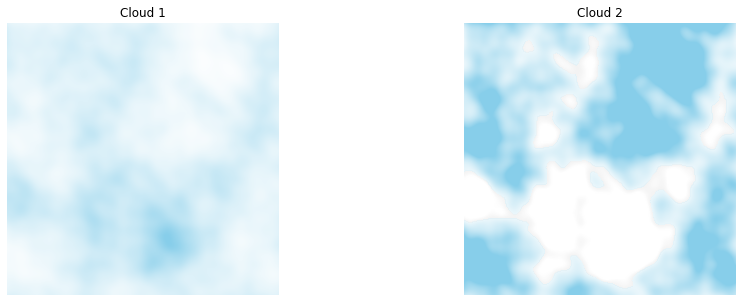

In [19]:
f, ([ax1, ax2]) = plt.subplots(1, 2, figsize = (15, 5))
for axi in [ax1, ax2]:
    axi.axis("Off") 


ax1.set_title("Cloud 1")
ax1.imshow(cloud1, vmin=0, vmax=1)

ax2.set_title("Cloud 2")
ax2.imshow(cloud2, vmin=0, vmax=1)

plt.show()

In [20]:
# render 3D terain
n = 256
seed = 777

pic_terain = []

for x in range(n):
    row = []
    for y in range(n):
        point =        noise_2d(x, y, 1, seed)
        point += 0.5 * noise_2d(x, y, 2, seed)
        point += 0.25 * noise_2d(x, y, 4, seed)
        point += 0.125 * noise_2d(x, y, 8, seed)

        point += 1
        point /= 2

        row.append(point)
    
    pic_terain.append(row)

n64_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 
            20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 
            37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 
            54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]

n256_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 
             19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 
             36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 
             53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 
             70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 
             87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 
             104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 
             118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 
             132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 
             146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 
             160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 
             174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 
             188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 
             202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 
             216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 
             230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 
             244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255]

In [21]:
fig = go.Figure(go.Surface(
    x = n256_list,
    y = n256_list,
    z = pic_terain,
    colorscale=[[0.0, "rgb(19,109,21)"],
                [0.1111111111111111, "rgb(17,124,19)"],
                [0.2222222222222222, "rgb(19,133,16)"],
                [0.3333333333333333, "rgb(38,139,7)"],
                [0.4444444444444444, "rgb(70, 120, 70)"],
                [0.5555555555555556, "rgb(110,116,126)"],
                [0.6666666666666666, "rgb(121,117,130)"],
                [0.7777777777777778, "rgb(121,117,130)"],
                [0.8888888888888888, "rgb(230, 230, 230)"],
                [1.0, "rgb(255, 255, 255)"]]
))
fig.update_layout(
        scene = {
            "xaxis": {"nticks": 20},
            "zaxis": {"nticks": 4},
            'camera_eye': {"x": 0.7, "y": 0.7, "z": 0.3},
            "aspectratio": {"x": 1, "y": 1, "z": 0.2}
        })
fig.show()

#### Some interesting effects appear when we start playing with the function

The same setup used for the first images is used, but the noise value is additionaly smoothed again. As we saw the curve of the smoothing function "stays" for longer around 0 and 1 on the y axis. This exactly is represented here. The whites and blacks are more white and black, and the mids are flatten.

    def run_perlin_noise(n, octave=1, permutation_table=None):
    
        pic = np.zeros((n, n, 1))    
        for x in range(n):
            for y in range(n):
                point = noise_2d(x, y, octave, permutation_table)

                # ---this line added:
                point = fade(point)
                # ------------------

                point += 1
                point /= 2
                pic[x,y] = point
        return pic

<img src="Images/test1.png" alt="Drawing"  style = "width: 845px;" />
<i><center>Noise value smoothed once again.</center></i>

Other cool effect manifest itself when we add additional smoothing to the dot products in the corners or to the offset values.

    instead of:
        value = lerp(u,
            lerp(v, dot_BL, dot_TL),
            lerp(v, dot_BR, dot_TR)
        )
    we substitude with:
        value = lerp(u,
            lerp(v, fade(dot_BL), fade(dot_TL)),
            lerp(v, fade(dot_BR), fade(dot_TR))
        )
    

<img src="Images/test2.png" alt="Drawing"  style = "width: 845px;" />
<i><center>Dot products smoothed.</center></i>

    these lines added right after the calculation of xi and yi
        xi = fade(xi)
        yi = fade(yi)

<img src="Images/test3.png" alt="Drawing"  style = "width: 845px;" />
<i><center>Offset values smoothed.</center></i>

Other effects and natural phenomenons like sea waves, sunsets, stormy clouds can be simulated. The 3D Perlin noise is used for fluid simulations, fire and explosions, etc. It's important to mention that Ken Perlin is the creator of the Simplex noise - improved version of his first noise, but it's algorithm is way more complicated. It involves n-dimensional hypercubic honeycomb instead of used in the classic noise sqaure and cube, vector fields and that's just part of it. The simplex noise is faster for computing. The complexity is $O(n^{2})$ for $n$ dimensions instead of the $O(n\,2^{n})$ of the classic noise. Bellow you can see some pictures generated with simplex noise.

<img src="Images/simplex0.png" alt="Drawing"  style = "width: 640px;" />

<img src="Images/simplex1.png" alt="Drawing"  style = "width: 800px;" />

<img src="Images/simplex2.png" alt="Drawing"  style = "width: 440px;" />







<i><center>With that said we can wish all the noise our neighbours produce is Perlin noise.</center></i>

<img src="Images/Noisy.jpg" alt="Drawing"  style = "width: 440px;" />



Used materials:

https://web.archive.org/web/20160308191327/http://noisemachine.com/talk1/2.html

https://www.khanacademy.org/computing/computer-programming/programming-natural-simulations/programming-noise/pc/challenge-noisy-step-walker


https://web.archive.org/web/20200622111717/https://www.scratchapixel.com/lessons/procedural-generation-virtual-worlds/procedural-patterns-noise-part-1

http://kitfox.com/projects/perlinNoiseMaker/


https://eev.ee/blog/2016/05/29/perlin-noise/


https://weber.itn.liu.se/~stegu/TNM022-2005/perlinnoiselinks/paper445.pdf


https://rtouti.github.io/graphics/perlin-noise-algorithm